In [1]:
import random
import time
from typing import List

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
#from loguru import logger
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

try:
  from transformers import BertConfig, BertModel, BertTokenizer
except:
  !pip install transformers
  from transformers import BertConfig, BertModel, BertTokenizer

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Nov 30 11:30:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/quora-question-pairs/train/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of unique questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of unique questions in the training data: 537933
Number of questions that appear multiple times: 111780


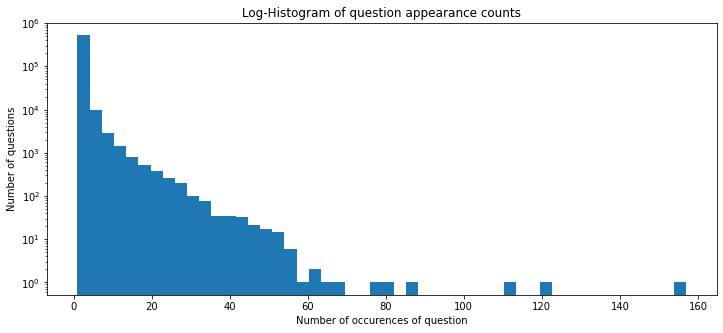

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

### Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

### we have a 37% positive class in this dataset.

# SIMCSE

In [7]:
import random
import time
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [8]:
def simcse_sup_loss(y_pred: 'tensor') -> 'tensor':
    """有监督的损失函数
    y_pred (tensor): bert的输出, [batch_size * 2, 768]
    
    """
    # 得到y_pred对应的label, 每第三句没有label, 跳过, label= [1, 0, 4, 3, ...]
    # torch.arrange(10) [0,1,2,3,4,5,6,7,8,9]
    y_true = torch.arange(y_pred.shape[0], device=DEVICE)
    
    '''
    tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
    tensor([ True,  True, False,  True,  True, False,  True,  True, False,  True])
    tensor([0, 1, 3, 4, 6, 7, 9])
    '''
    #use_row = torch.where((y_true + 1) % 3 != 0)[0]
    
    '''
    torch.arange(10)
    tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    torch.arange(10) + 1
    tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
    (torch.arange(10) + 1) % 3 != 0
    tensor([ True,  True, False,  True,  True, False,  True,  True, False,  True])
    use_row  = torch.where((torch.arange(10) + 1) % 3 != 0)[0]
    tensor([0, 1, 3, 4, 6, 7, 9])
    use_row % 3
    tensor([0, 1, 0, 1, 0, 1, 0])
    (use_row - use_row % 3 * 2) 
    tensor([ 0, -1,  3,  2,  6,  5,  9])
    (use_row - use_row % 3 * 2) + 1
    tensor([ 1,  0,  4,  3,  7,  6, 10])
    意思是第0句话的postiive pair 是 1
    意思是第1句话的postiive pair 是 0
    意思是第4句话的postiive pair 是 3
    意思是第3句话的postiive pair 是 4
    '''
    
    #y_true = (use_row - use_row % 3 * 2) + 1
    y_true = (y_true - y_true % 2 * 2) + 1
    # batch内两两计算相似度, 得到相似度矩阵(对角矩阵)
    
    '''
    y_pred.unsqueeze(1)
    tensor([[ 1],
            [ 0],
            [ 4],
            [ 3],
            [ 7],
            [ 6],
            [10]])

    y_pred.unsqueeze(0)
    tensor([[ 1,  0,  4,  3,  7,  6, 10]])
    '''
    sim = F.cosine_similarity(y_pred.unsqueeze(1), y_pred.unsqueeze(0), dim=-1)
    # 将相似度矩阵对角线置为很小的值, 消除自身的影响
    
    '''
    pred.shape[0]
    7
    
    torch.eye(y_pred.shape[0], device=DEVICE)
    tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
    '''
    sim = sim - torch.eye(y_pred.shape[0], device=DEVICE) * 1e12
    # 选取有效的行
    '''
    应该是忽略掉第三个input，第三个是label
    '''
    #sim = torch.index_select(sim, 0, use_row)
    # 相似度矩阵除以温度系数
    sim = sim / 0.05
    # 计算相似度矩阵与y_true的交叉熵损失
    loss = F.cross_entropy(sim, y_true)
    return torch.mean(loss)

In [9]:
def eval(model, dataloader) -> float:
    """模型评估函数 
    批量预测, 计算cos_sim, 转成numpy数组拼接起来, 一次性求spearman相关度
    """
    model.eval()
    sim_tensor = torch.tensor([], device=DEVICE)
    label_array = np.array([])
    output_array = []
    
    with torch.no_grad():
        for source, target, label in dataloader:
            # source        [batch, 1, seq_len] -> [batch, seq_len]
            source_input_ids = source['input_ids'].squeeze(1).to(DEVICE)
            source_attention_mask = source['attention_mask'].squeeze(1).to(DEVICE)
            source_token_type_ids = source['token_type_ids'].squeeze(1).to(DEVICE)
            source_pred = model(source_input_ids, source_attention_mask, source_token_type_ids)
            # target        [batch, 1, seq_len] -> [batch, seq_len]
            target_input_ids = target['input_ids'].squeeze(1).to(DEVICE)
            target_attention_mask = target['attention_mask'].squeeze(1).to(DEVICE)
            target_token_type_ids = target['token_type_ids'].squeeze(1).to(DEVICE)
            target_pred = model(target_input_ids, target_attention_mask, target_token_type_ids)
            # concat
            sim = F.cosine_similarity(source_pred, target_pred, dim=-1)
            sim_tensor = torch.cat((sim_tensor, sim), dim=0)
            label_array = np.append(label_array, np.array(label))  
            output_array.append(target_pred.cpu().detach().numpy())  
            
    # corrcoef       
    return spearmanr(label_array, sim_tensor.cpu().numpy()).correlation, sim_tensor, label_array, output_array

In [10]:
class SimcseModel(nn.Module):
    """Simcse有监督模型定义"""
    def __init__(self, pretrained_model: str, pooling: str):
        super(SimcseModel, self).__init__()
        # config = BertConfig.from_pretrained(pretrained_model)   # 有监督不需要修改dropout
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.pooling = pooling
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        
        # out = self.bert(input_ids, attention_mask, token_type_ids)
        out = self.bert(input_ids, attention_mask, token_type_ids, output_hidden_states=True)

        if self.pooling == 'cls':
            return out.last_hidden_state[:, 0]  # [batch, 768]
                  

# Read data

In [11]:
#creat a dictionary, each sentence has a unique idx
def question_dict(df):
    sen2idx = {}
    idx2sen = {}
    for i in range(len(df)):
        qid1 = df['qid1'][i] 
        qid2 = df['qid2'][i] 
        question1 = df['question1'][i] 
        question2 = df['question2'][i] 

        try:
            output_qid1 = sen2idx[question1]
            output_question1 = idx2sen[qid1]
        except:
            sen2idx[question1] = qid1
            idx2sen[qid1] = question1

        try:
            output_qid2 = sen2idx[question2]
            output_question2 = idx2sen[qid2]
        except:
            sen2idx[question2] = qid2
            idx2sen[qid2] = question2
        
    return sen2idx, idx2sen

sen2idx, idx2sen = question_dict(df_train)

In [12]:
df_train_duplicate = df_train[df_train.is_duplicate == 1]
df_train_duplicate.reset_index(inplace = True)
df_train_duplicate.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [13]:
All_train_data= [(df_train_duplicate['question1'][i], df_train_duplicate['question2'][i], 
             str(df_train_duplicate['is_duplicate'][i])) for i in range(len(df_train_duplicate))]

In [14]:
length = int(len(All_train_data)/3)
train_data = All_train_data[:length]
len(train_data)

49754

In [15]:
def read_file(path):
    
    df = pd.read_csv(path, header=None, warn_bad_lines = False, error_bad_lines = False)

    Data = []
    for i in range(len(df.index)):
        item = df.iloc[i][0].split('\t')
        Data.append([item[5],item[6],item[4]])
        
    return Data

In [16]:
eval_data = read_file('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/dataset/STS/STSBenchmark/sts-dev.csv')
test_data = read_file('/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/dataset/STS/STSBenchmark/sts-test.csv')

## Dataloader

In [17]:
class TrainDataset(Dataset):
    """训练数据集, 重写__getitem__和__len__方法
    """
    def __init__(self, data: List):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def text_2_id(self, text: str):
        return tokenizer([text[0], text[1]], max_length=MAXLEN, 
                         truncation=True, padding='max_length', return_tensors='pt')
    
    def __getitem__(self, index: int):
        return self.text_2_id(self.data[index])

In [18]:
class TestDataset(Dataset):
    """测试数据集, 重写__getitem__和__len__方法
    """
    def __init__(self, data: List):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def text_2_id(self, text: str):
        return tokenizer(text, max_length=MAXLEN, truncation=True, 
                         padding='max_length', return_tensors='pt')
    
    def __getitem__(self, index):
        line = self.data[index]
        return self.text_2_id([line[0]]), self.text_2_id([line[1]]), float(line[2])

In [19]:
BATCH_SIZE = 128
MAXLEN = 64

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')    

train_dataloader = DataLoader(TrainDataset(train_data), batch_size=BATCH_SIZE)
dev_dataloader = DataLoader(TestDataset(eval_data), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(TestDataset(test_data), batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# train

In [20]:
EPOCHS = 1
LR = 1e-5
POOLING = 'cls'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
#DEVICE = 'cpu'

SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/CSCI 544 course project/saved_model/simcse_sup.pt'

assert POOLING in ['cls', 'pooler', 'last-avg', 'first-last-avg']

In [21]:
# load model    
model_path = 'bert-base-uncased'

model = SimcseModel(pretrained_model = model_path, pooling = POOLING)
model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
'''
c = 1
with torch.no_grad():
    for batch_idx, source in enumerate(tqdm(train_dataloader), start=1):
        if c == 3:
            break
        else:
            c+=1
            print('********')
        print('print(batch_idx)')
        print(batch_idx)
        print('input_ids')
        print(source.get('input_ids').size())
        print(source.get('input_ids').view(real_batch_num * 2, -1).size())
        print('attention_mask')
        print(source.get('attention_mask').size())
        print(source.get('token_type_ids').view(real_batch_num * 2, -1).size())
        print('token_type_idx)')
        print(source.get('token_type_ids').size())
        print(source.get('token_type_ids').view(real_batch_num * 2, -1).size())
        
        real_batch_num = source.get('input_ids').shape[0]
        input_ids = source.get('input_ids').view(real_batch_num * 2, -1).to(DEVICE)
        attention_mask = source.get('attention_mask').view(real_batch_num * 2, -1).to(DEVICE)
        token_type_ids = source.get('token_type_ids').view(real_batch_num * 2, -1).to(DEVICE)
        
        out = model(input_ids, attention_mask, token_type_ids)
        loss = simcse_sup_loss(out)
        
        print('predict')
        print(out.size())
'''

"\nc = 1\nwith torch.no_grad():\n    for batch_idx, source in enumerate(tqdm(train_dataloader), start=1):\n        if c == 3:\n            break\n        else:\n            c+=1\n            print('********')\n        print('print(batch_idx)')\n        print(batch_idx)\n        print('input_ids')\n        print(source.get('input_ids').size())\n        print(source.get('input_ids').view(real_batch_num * 2, -1).size())\n        print('attention_mask')\n        print(source.get('attention_mask').size())\n        print(source.get('token_type_ids').view(real_batch_num * 2, -1).size())\n        print('token_type_idx)')\n        print(source.get('token_type_ids').size())\n        print(source.get('token_type_ids').view(real_batch_num * 2, -1).size())\n        \n        real_batch_num = source.get('input_ids').shape[0]\n        input_ids = source.get('input_ids').view(real_batch_num * 2, -1).to(DEVICE)\n        attention_mask = source.get('attention_mask').view(real_batch_num * 2, -1).to(DEVIC

In [23]:
model.train()
best = 0

for epoch in range(EPOCHS):
    torch.manual_seed(1234)
    
    for batch_idx, source in enumerate(tqdm(train_dataloader), start=1):
        
        # 维度转换 [batch, 3, seq_len] -> [batch * 3, sql_len]
        real_batch_num = source.get('input_ids').shape[0]
        input_ids = source.get('input_ids').view(real_batch_num * 2, -1).to(DEVICE)
        attention_mask = source.get('attention_mask').view(real_batch_num * 2, -1).to(DEVICE)
        token_type_ids = source.get('token_type_ids').view(real_batch_num * 2, -1).to(DEVICE)
        
        # 训练
        out = model(input_ids, attention_mask, token_type_ids)
        loss = simcse_sup_loss(out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # 评估
        if batch_idx % 10 == 0:
            print(f'loss: {loss.item():.4f}')
            corrcoef, sim_tensor, label_array, output_array = eval(model, dev_dataloader)
            model.train()
            if best < corrcoef:
                early_stop_batch = 0
                best = corrcoef
                torch.save(model.state_dict(), SAVE_PATH)
                print(f"higher corrcoef: {best:.4f} in batch: {batch_idx}, save model")
                continue
            
                
                
        torch.cuda.empty_cache()

  2%|▏         | 9/389 [00:17<12:00,  1.90s/it]

loss: 1.5866


  3%|▎         | 10/389 [00:30<35:09,  5.57s/it]

higher corrcoef: 0.4441 in batch: 10, save model


  5%|▍         | 19/389 [00:47<12:38,  2.05s/it]

loss: 0.6444


  5%|▌         | 20/389 [00:56<23:46,  3.87s/it]

higher corrcoef: 0.5936 in batch: 20, save model


  7%|▋         | 29/389 [01:13<11:57,  1.99s/it]

loss: 0.6900


  8%|▊         | 30/389 [01:21<23:18,  3.89s/it]

higher corrcoef: 0.6711 in batch: 30, save model


 10%|█         | 39/389 [01:38<11:38,  1.99s/it]

loss: 0.3965


 10%|█         | 40/389 [01:46<22:09,  3.81s/it]

higher corrcoef: 0.7102 in batch: 40, save model


 13%|█▎        | 49/389 [02:04<11:18,  2.00s/it]

loss: 0.3183


 13%|█▎        | 50/389 [02:12<21:31,  3.81s/it]

higher corrcoef: 0.7306 in batch: 50, save model


 15%|█▌        | 59/389 [02:29<10:57,  1.99s/it]

loss: 0.4840


 15%|█▌        | 60/389 [02:37<21:04,  3.84s/it]

higher corrcoef: 0.7430 in batch: 60, save model


 18%|█▊        | 69/389 [02:54<10:36,  1.99s/it]

loss: 0.2696


 18%|█▊        | 70/389 [03:02<20:23,  3.83s/it]

higher corrcoef: 0.7504 in batch: 70, save model


 20%|██        | 79/389 [03:19<10:16,  1.99s/it]

loss: 0.2851


 21%|██        | 80/389 [03:28<19:40,  3.82s/it]

higher corrcoef: 0.7547 in batch: 80, save model


 23%|██▎       | 89/389 [03:45<10:00,  2.00s/it]

loss: 0.2025


 23%|██▎       | 90/389 [03:53<19:02,  3.82s/it]

higher corrcoef: 0.7587 in batch: 90, save model


 25%|██▌       | 99/389 [04:10<09:40,  2.00s/it]

loss: 0.2803


 26%|██▌       | 100/389 [04:18<18:13,  3.78s/it]

higher corrcoef: 0.7639 in batch: 100, save model


 28%|██▊       | 109/389 [04:35<09:14,  1.98s/it]

loss: 0.2362


 28%|██▊       | 110/389 [04:43<17:33,  3.78s/it]

higher corrcoef: 0.7688 in batch: 110, save model


 31%|███       | 119/389 [05:00<08:54,  1.98s/it]

loss: 0.3232


 31%|███       | 120/389 [05:08<16:56,  3.78s/it]

higher corrcoef: 0.7716 in batch: 120, save model


 33%|███▎      | 129/389 [05:26<08:37,  1.99s/it]

loss: 0.4467


 33%|███▎      | 130/389 [05:33<16:17,  3.77s/it]

higher corrcoef: 0.7732 in batch: 130, save model


 36%|███▌      | 139/389 [05:51<08:16,  1.99s/it]

loss: 0.2110


 36%|███▌      | 140/389 [05:59<15:39,  3.77s/it]

higher corrcoef: 0.7755 in batch: 140, save model


 38%|███▊      | 149/389 [06:16<07:57,  1.99s/it]

loss: 0.2332


 39%|███▊      | 150/389 [06:24<15:09,  3.81s/it]

higher corrcoef: 0.7785 in batch: 150, save model


 41%|████      | 159/389 [06:41<07:37,  1.99s/it]

loss: 0.2778


 41%|████      | 160/389 [06:49<14:26,  3.78s/it]

higher corrcoef: 0.7812 in batch: 160, save model


 43%|████▎     | 169/389 [07:06<07:15,  1.98s/it]

loss: 0.3202


 44%|████▎     | 170/389 [07:14<13:48,  3.78s/it]

higher corrcoef: 0.7817 in batch: 170, save model


 46%|████▌     | 179/389 [07:31<06:57,  1.99s/it]

loss: 0.2945


 46%|████▋     | 180/389 [07:39<13:16,  3.81s/it]

higher corrcoef: 0.7818 in batch: 180, save model


 49%|████▊     | 189/389 [07:57<06:38,  1.99s/it]

loss: 0.3436


 49%|████▉     | 190/389 [08:05<12:55,  3.90s/it]

higher corrcoef: 0.7841 in batch: 190, save model


 51%|█████     | 199/389 [08:22<06:17,  1.99s/it]

loss: 0.1551


 51%|█████▏    | 200/389 [08:30<12:03,  3.83s/it]

higher corrcoef: 0.7865 in batch: 200, save model


 54%|█████▎    | 209/389 [08:47<05:57,  1.99s/it]

loss: 0.1703


 54%|█████▍    | 210/389 [08:56<11:25,  3.83s/it]

higher corrcoef: 0.7884 in batch: 210, save model


 56%|█████▋    | 219/389 [09:13<05:38,  1.99s/it]

loss: 0.1617


 57%|█████▋    | 220/389 [09:21<10:42,  3.80s/it]

higher corrcoef: 0.7902 in batch: 220, save model


 59%|█████▉    | 229/389 [09:38<05:18,  1.99s/it]

loss: 0.2104


 59%|█████▉    | 230/389 [09:46<10:09,  3.83s/it]

higher corrcoef: 0.7905 in batch: 230, save model


 61%|██████▏   | 239/389 [10:03<04:59,  1.99s/it]

loss: 0.2344


 62%|██████▏   | 240/389 [10:11<09:27,  3.81s/it]

higher corrcoef: 0.7905 in batch: 240, save model


 64%|██████▍   | 249/389 [10:29<04:39,  1.99s/it]

loss: 0.2316


 64%|██████▍   | 250/389 [10:37<08:51,  3.83s/it]

higher corrcoef: 0.7909 in batch: 250, save model


 67%|██████▋   | 259/389 [10:54<04:19,  1.99s/it]

loss: 0.2589


 67%|██████▋   | 260/389 [11:02<08:16,  3.85s/it]

higher corrcoef: 0.7913 in batch: 260, save model


 69%|██████▉   | 269/389 [11:19<04:00,  2.00s/it]

loss: 0.1958


 69%|██████▉   | 270/389 [11:27<07:38,  3.85s/it]

higher corrcoef: 0.7922 in batch: 270, save model


 72%|███████▏  | 279/389 [11:45<03:38,  1.99s/it]

loss: 0.2229


 72%|███████▏  | 280/389 [11:53<06:58,  3.84s/it]

higher corrcoef: 0.7946 in batch: 280, save model


 74%|███████▍  | 289/389 [12:10<03:18,  1.99s/it]

loss: 0.1942


 75%|███████▍  | 290/389 [12:18<06:21,  3.85s/it]

higher corrcoef: 0.7975 in batch: 290, save model


 77%|███████▋  | 299/389 [12:35<02:58,  1.99s/it]

loss: 0.1589


 77%|███████▋  | 300/389 [12:44<05:43,  3.86s/it]

higher corrcoef: 0.7992 in batch: 300, save model


 79%|███████▉  | 309/389 [13:01<02:39,  1.99s/it]

loss: 0.3437


 80%|███████▉  | 310/389 [13:09<04:58,  3.78s/it]

higher corrcoef: 0.7993 in batch: 310, save model


 82%|████████▏ | 319/389 [13:26<02:19,  2.00s/it]

loss: 0.1433


 82%|████████▏ | 320/389 [13:34<04:21,  3.79s/it]

higher corrcoef: 0.8000 in batch: 320, save model


 85%|████████▍ | 329/389 [13:51<01:59,  2.00s/it]

loss: 0.2091


 85%|████████▍ | 330/389 [13:59<03:43,  3.78s/it]

higher corrcoef: 0.8007 in batch: 330, save model


 87%|████████▋ | 339/389 [14:16<01:39,  1.98s/it]

loss: 0.0815


 87%|████████▋ | 340/389 [14:24<03:04,  3.76s/it]

higher corrcoef: 0.8031 in batch: 340, save model


 90%|████████▉ | 349/389 [14:42<01:20,  2.01s/it]

loss: 0.1984


 90%|████████▉ | 350/389 [14:50<02:27,  3.79s/it]

higher corrcoef: 0.8043 in batch: 350, save model


 92%|█████████▏| 359/389 [15:07<00:59,  1.98s/it]

loss: 0.1651


 95%|█████████▍| 369/389 [15:30<00:38,  1.95s/it]

loss: 0.3009


 95%|█████████▌| 370/389 [15:38<01:12,  3.80s/it]

higher corrcoef: 0.8046 in batch: 370, save model


 97%|█████████▋| 379/389 [15:55<00:19,  1.99s/it]

loss: 0.4117


 98%|█████████▊| 380/389 [16:03<00:34,  3.81s/it]

higher corrcoef: 0.8057 in batch: 380, save model


100%|██████████| 389/389 [16:20<00:00,  2.52s/it]


In [24]:
model.load_state_dict(torch.load(SAVE_PATH))
dev_corrcoef, dev_sim_tensor, dev_label_array, output_array = eval(model, dev_dataloader)
test_corrcoef, test_sim_tensor, test_label_array, output_array = eval(model, test_dataloader)
print(f'dev_corrcoef: {dev_corrcoef:.4f}')
print(f'test_corrcoef: {test_corrcoef:.4f}')

dev_corrcoef: 0.8057
test_corrcoef: 0.7589


In [25]:
torch.cuda.empty_cache()